In [1]:
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import snapatac2 as snap
import numpy as np
import pandas as pd
import os
import scanpy.external as sce
#adata_concat = snap.read_dataset('output/mouse_brain.h5ads')

In [2]:
file = "/data2st1/junyi/output/mouse_brain_dar.h5ad"

In [3]:
adata = anndata.read_h5ad(file)

/home/junyichen/anaconda3/envs/snapatac2/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


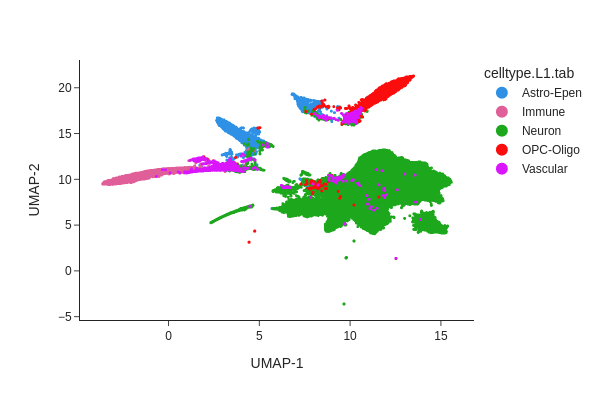

In [15]:
snap.pl.umap(adata, color="celltype.L1.tab", interactive=False,  marker_size=3)


In [19]:
adata_AMY_neuron = adata[(adata.obs['sample'].str.contains("AMY")) & (adata.obs['celltype.L1.tab'].str.contains("Neuron")) ].copy()
adata_AMY_neuron


AnnData object with n_obs × n_vars = 32233 × 526402
    obs: 'sample', 'sample_barcode', 'obs_names', 'celltype.L2.p', 'celltype.L1.p', 'leiden', 'celltype.L1.GBoost', 'celltype.L1.tab'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'macs3', 'reference_sequences', 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_spectral_harmony', 'X_spectral_mnn', 'X_umap', 'fragment_paired'
    obsp: 'distances'

In [22]:
adata_AMY_neuron.obs['expriment'] = adata_AMY_neuron.obs['sample'].str[:2]


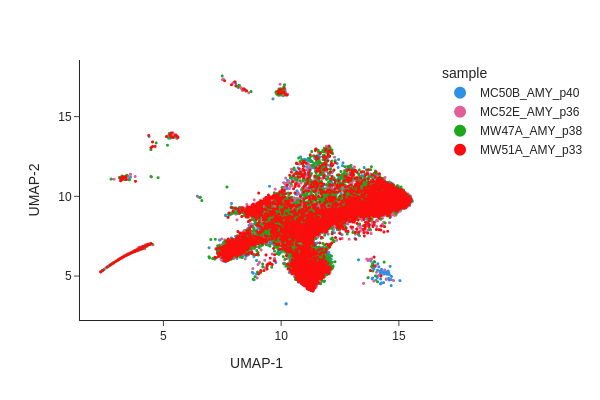

In [28]:
snap.pl.umap(adata_AMY_neuron, color="sample", interactive=False,  marker_size=3)


In [25]:
%%time
snap.tl.macs3(adata_AMY_neuron, groupby='expriment')


2025-03-03 16:35:17 - INFO - Exporting fragments...
2025-03-03 16:43:57 - INFO - Calling peaks...
100%|██████████| 2/2 [55:12<00:00, 1656.29s/it]


CPU times: user 12min 16s, sys: 12min 56s, total: 25min 12s
Wall time: 1h 3min 54s


In [27]:
adata_AMY_neuron

AnnData object with n_obs × n_vars = 32233 × 526402
    obs: 'sample', 'sample_barcode', 'obs_names', 'celltype.L2.p', 'celltype.L1.p', 'leiden', 'celltype.L1.GBoost', 'celltype.L1.tab', 'expriment'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'macs3', 'reference_sequences', 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_spectral_harmony', 'X_spectral_mnn', 'X_umap', 'fragment_paired'
    obsp: 'distances'

In [29]:
%%time
peaks = snap.tl.merge_peaks(adata_AMY_neuron.uns['macs3'], snap.genome.GRCm39)
peaks.head()


CPU times: user 5.16 s, sys: 1.02 s, total: 6.18 s
Wall time: 1.49 s


Peaks,MC,MW
str,bool,bool
"""chr1:3051682-3052183""",true,true
"""chr1:3055679-3056180""",true,true
"""chr1:3066403-3066904""",true,true
"""chr1:3082708-3083209""",true,true
"""chr1:3165019-3165520""",true,true


In [31]:
%%time
peak_mat = snap.pp.make_peak_matrix(adata_AMY_neuron, use_rep=peaks['Peaks'])
peak_mat


CPU times: user 20min 53s, sys: 4min, total: 24min 53s
Wall time: 34.2 s


AnnData object with n_obs × n_vars = 32233 × 382436
    obs: 'sample', 'sample_barcode', 'obs_names', 'celltype.L2.p', 'celltype.L1.p', 'leiden', 'celltype.L1.GBoost', 'celltype.L1.tab', 'expriment'

In [82]:
peak_mat.layers['raw'] = peak_mat.X.copy()

In [83]:
sc.pp.normalize_total(peak_mat)

In [84]:
sc.pp.log1p(peak_mat)

In [ ]:
%%time
sc.tl.rank_genes_groups(peak_mat, groupby='expriment', method='wilcoxon',pts=True)

... storing 'expriment' as categorical


In [100]:
peak_mat.obsm['X_umap'] = adata_AMY_neuron.obsm['X_umap']

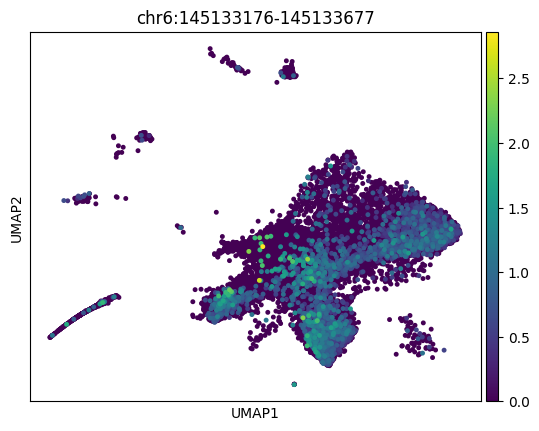

In [121]:
sc.pl.umap(peak_mat, color='chr6:145133176-145133677', size=50, legend_loc='on data')

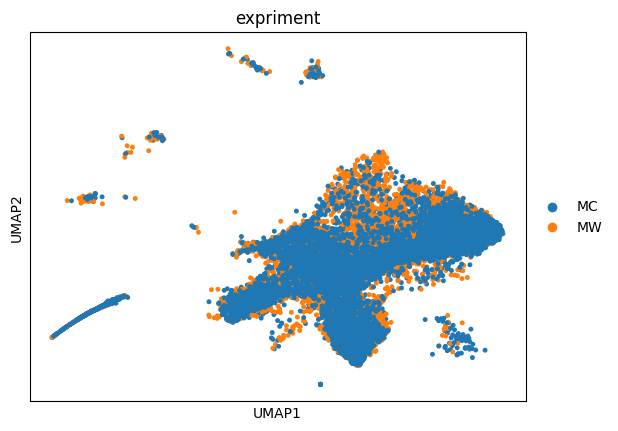

In [117]:
sc.pl.umap(peak_mat, color='expriment', size=50)

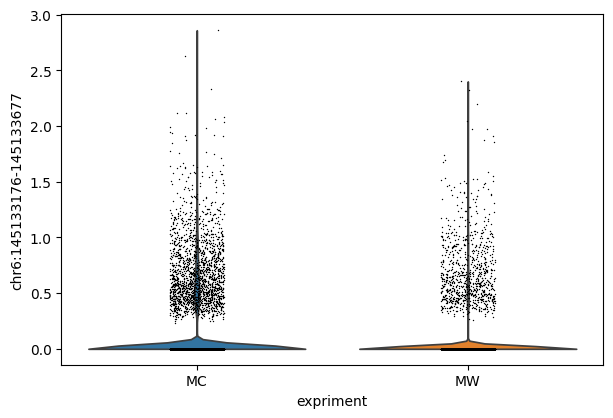

In [120]:
sc.pl.violin(peak_mat, keys='chr6:145133176-145133677', groupby='expriment')

In [93]:
df = sc.get.rank_genes_groups_df(peak_mat, group='MC', key='rank_genes_groups',pval_cutoff=0.05)

In [123]:
df.to_csv("output/AMY_neuron_MC_wilcoxon.csv")

In [141]:
df.sort_values('logfoldchanges',ascending=False).names.str.split(r'[-:]', expand=True).to_csv("output/AMY_neuron_MC_wilcoxon.bed",sep='\t', header=False, index=False) 

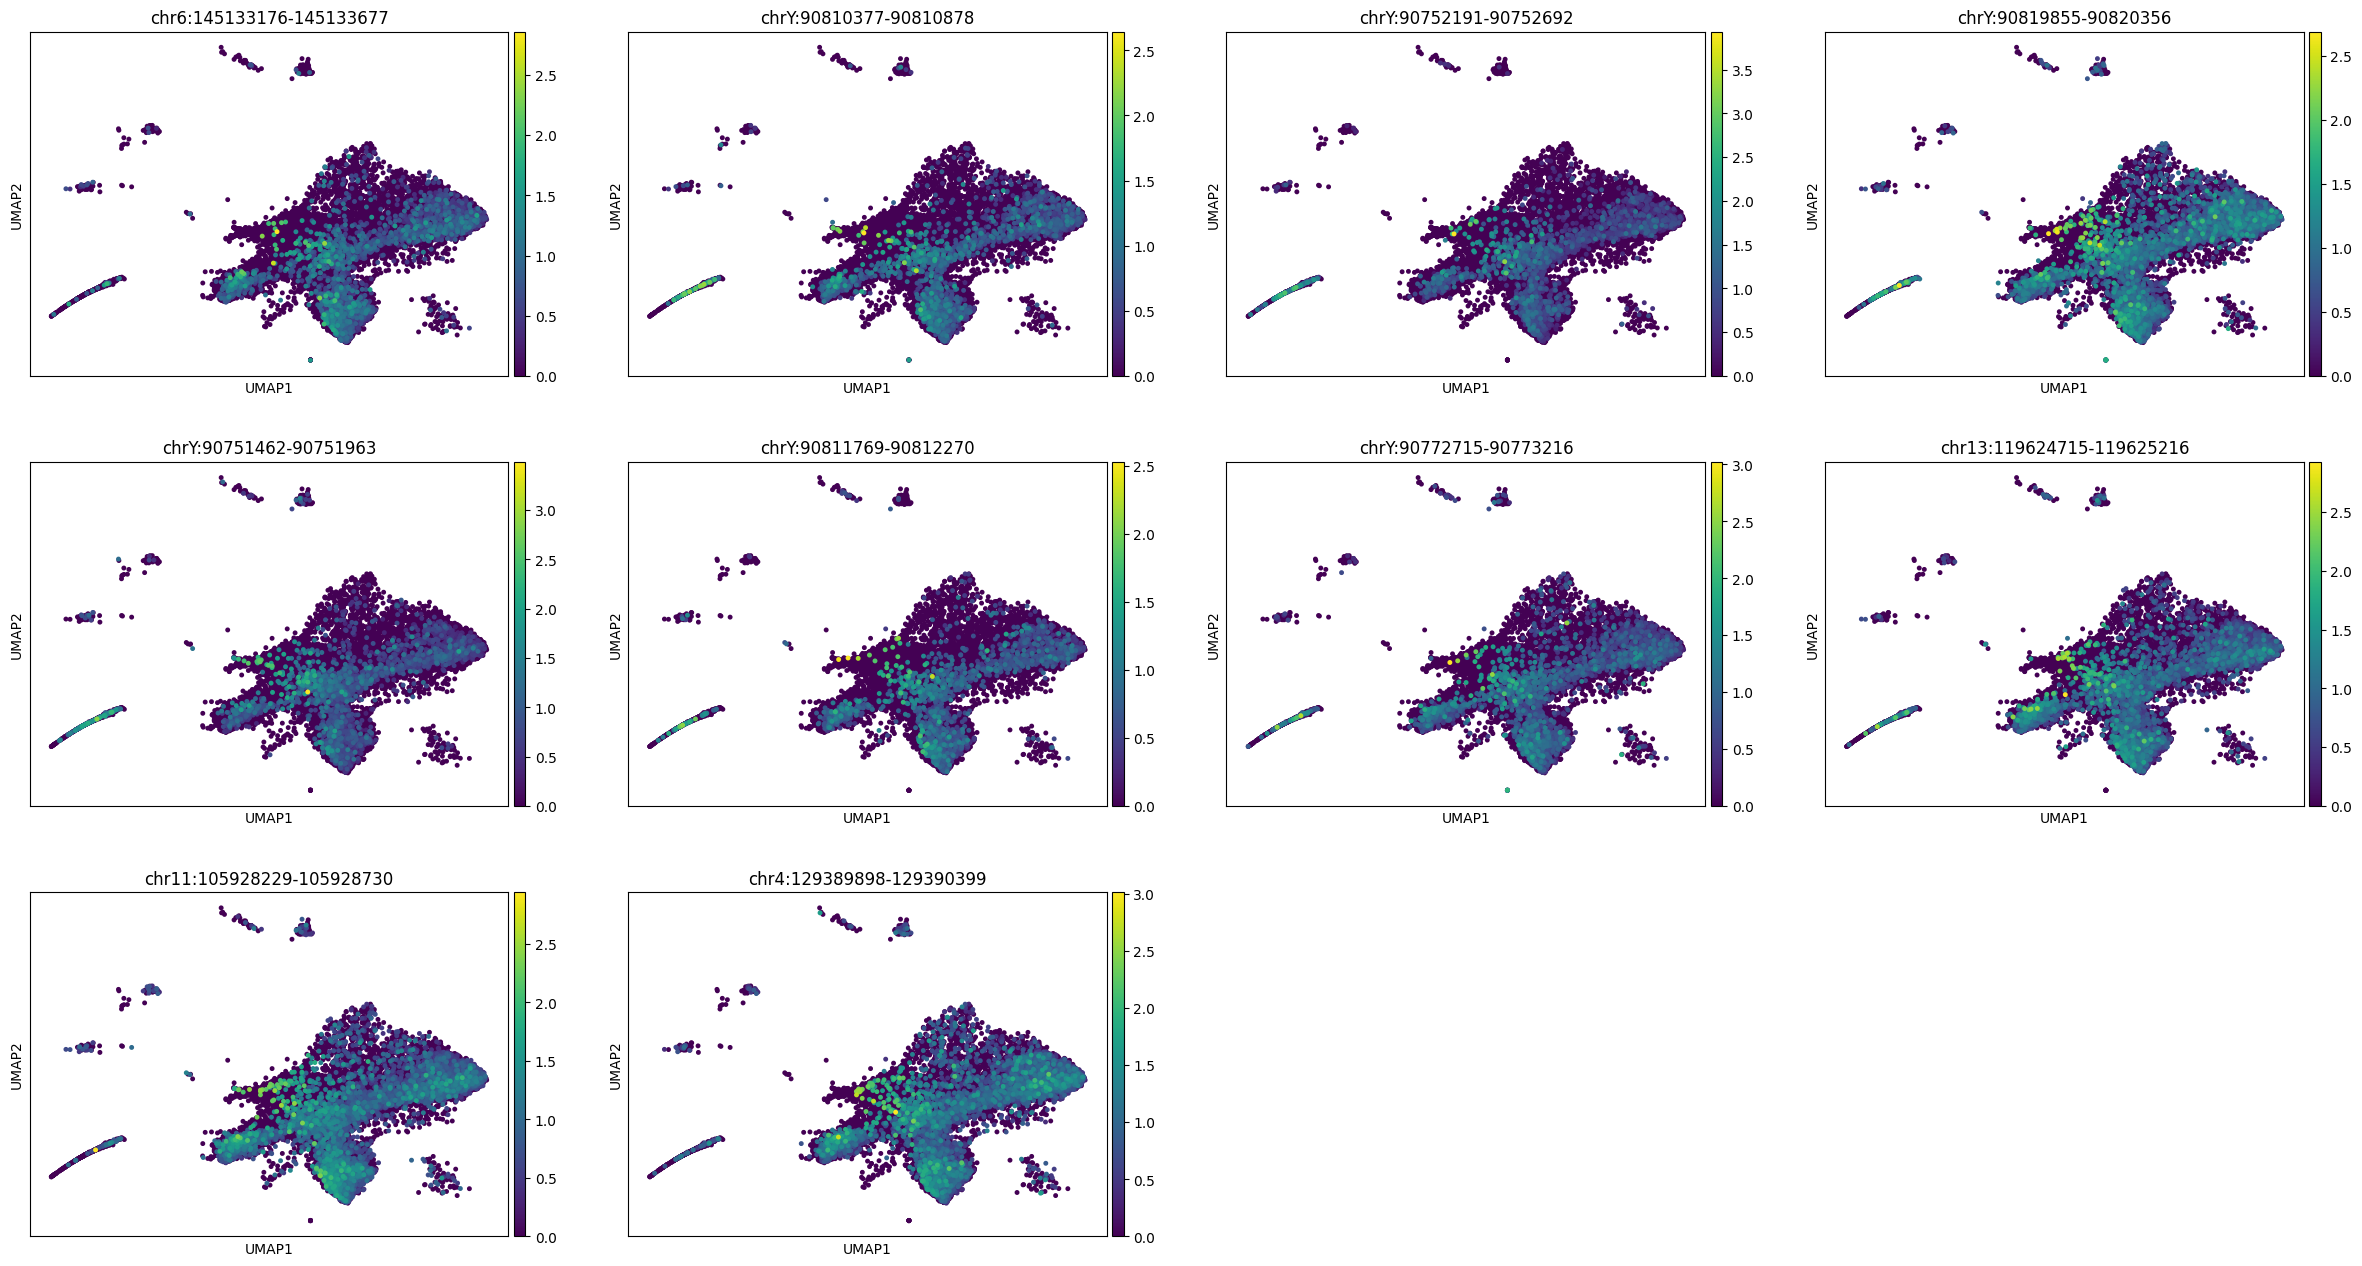

In [130]:
sc.pl.umap(peak_mat, color=df.sort_values('logfoldchanges',ascending=False).head(10).names, size=50)

In [142]:
peak_mat.uns['rank_genes_groups']

{'params': {'groupby': 'expriment',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('chr2:98497263-98497764', 'chr8:71318166-71318667'),
            ('chrY:90819855-90820356', 'chr6:28929338-28929839'),
            ('chr9:3024256-3024757', 'chr16:21023066-21023567'), ...,
            ('chr16:21023066-21023567', 'chr9:3024256-3024757'),
            ('chr6:28929338-28929839', 'chrY:90819855-90820356'),
            ('chr8:71318166-71318667', 'chr2:98497263-98497764')],
           dtype=[('MC', 'O'), ('MW', 'O')]),
 'scores': rec.array([(12.810204,   6.625257), (12.009475,   6.617537),
            (10.900932,   6.576906), ..., (-6.576906, -10.900932),
            (-6.617537, -12.009475), (-6.625257, -12.810204)],
           dtype=[('MC', '<f4'), ('MW', '<f4')]),
 'pvals': rec.array([(1.43757580e-37, 3.46644701e-11),
            (3.16851207e-33, 3.65233355e-11),
            (1.14082492e-27, 4.8

In [ ]:
# Create a pandas dataframe
df = pd.DataFrame({group + '_' + key: rank_gene_groups[key][group]
                   for group in rank_gene_groups.keys()
                   for key in ['names', 'scores']})

In [124]:
df_mw = sc.get.rank_genes_groups_df(peak_mat, group='MW', key='rank_genes_groups',pval_cutoff=0.05)

In [126]:
df_mw.to_csv("output/AMY_neuron_MW_wilcoxon.csv")

In [ ]:
# %%time
# marker_peaks = snap.tl.marker_regions(peak_mat, groupby='expriment', pvalue=0.05)


CPU times: user 9.21 s, sys: 912 ms, total: 10.1 s
Wall time: 10.1 s


Index(['chr2:98497263-98497764', 'chrY:90819855-90820356',
       'chr9:3024256-3024757', 'chr6:145133176-145133677',
       'chrY:90772715-90773216', 'chr11:105928229-105928730',
       'chr8:19834446-19834947', 'chr15:79127368-79127869',
       'chr17:24746782-24747283', 'chrY:90810377-90810878',
       'chrY:90751462-90751963', 'chr11:87313678-87314179',
       'chr7:3695933-3696434', 'chr13:119624715-119625216',
       'chrY:90752191-90752692', 'chr7:45353519-45354020',
       'chr4:129389898-129390399', 'chr7:24583281-24583782',
       'chr7:126807802-126808303', 'chrY:90811769-90812270',
       'chr6:125192185-125192686'],
      dtype='object', name='names')

In [149]:
df[df.logfoldchanges>0].set_index('names').index

Index(['chr2:98497263-98497764', 'chrY:90819855-90820356',
       'chr9:3024256-3024757', 'chr6:145133176-145133677',
       'chrY:90772715-90773216', 'chr11:105928229-105928730',
       'chr8:19834446-19834947', 'chr15:79127368-79127869',
       'chr17:24746782-24747283', 'chrY:90810377-90810878',
       'chrY:90751462-90751963', 'chr11:87313678-87314179',
       'chr7:3695933-3696434', 'chr13:119624715-119625216',
       'chrY:90752191-90752692', 'chr7:45353519-45354020',
       'chr4:129389898-129390399', 'chr7:24583281-24583782',
       'chr7:126807802-126808303', 'chrY:90811769-90812270',
       'chr6:125192185-125192686'],
      dtype='object', name='names')

In [151]:
df[df.logfoldchanges<0].set_index('names').index

Index(['chr8:23297883-23298384', 'chr16:7826779-7827280',
       'chr12:78048562-78049063', 'chr17:40156048-40156549',
       'chr12:69408074-69408575', 'chr12:104803341-104803842',
       'chr14:86396484-86396985', 'chr12:43873975-43874476',
       'chr5:144860088-144860589', 'chr16:27342456-27342957',
       'chr2:151943581-151944082', 'chr15:100821246-100821747',
       'chr7:73267981-73268482', 'chr8:122305343-122305844',
       'chr16:24320770-24321271', 'chr4:11966308-11966809',
       'chr4:156368337-156368838', 'chr5:84565037-84565538',
       'chr7:67914244-67914745', 'chr17:28741906-28742407',
       'chr4:46684063-46684564', 'chr8:95429977-95430478',
       'chr17:40156630-40157131', 'chr19:11988824-11989325',
       'chr12:51287911-51288412', 'chr11:119882014-119882515',
       'chr3:51102682-51103183', 'chr17:36542134-36542635',
       'chr4:151225005-151225506', 'chr6:94561081-94561582',
       'chr12:69418567-69419068', 'chr9:49901166-49901667',
       'chr19:21764225-21

In [153]:
marker_peaks = {"MC": df[df.logfoldchanges>0].set_index('names').index,"MW":df_mw[df_mw.logfoldchanges>0].set_index('names').index}

In [154]:
marker_peaks

{'MC': Index(['chr6:145133176-145133677', 'chrY:90810377-90810878',
        'chrY:90752191-90752692', 'chrY:90819855-90820356',
        'chrY:90751462-90751963', 'chrY:90811769-90812270',
        'chrY:90772715-90773216', 'chr13:119624715-119625216',
        'chr11:105928229-105928730', 'chr4:129389898-129390399',
        'chr7:45353519-45354020', 'chr11:87313678-87314179',
        'chr15:79127368-79127869', 'chr8:19834446-19834947',
        'chr9:3024256-3024757', 'chr2:98497263-98497764',
        'chr7:3695933-3696434', 'chr17:24746782-24747283',
        'chr7:24583281-24583782', 'chr7:126807802-126808303',
        'chr6:125192185-125192686'],
       dtype='object', name='names'),
 'MW': Index(['chr6:31780105-31780606', 'chrX:168769818-168770319',
        'chr6:28929338-28929839', 'chr16:24320770-24321271',
        'chr16:24290209-24290710', 'chr19:11979464-11979965',
        'chr8:12123609-12124110', 'chr9:63540096-63540597',
        'chr19:21764225-21764726', 'chr12:51287911-512884

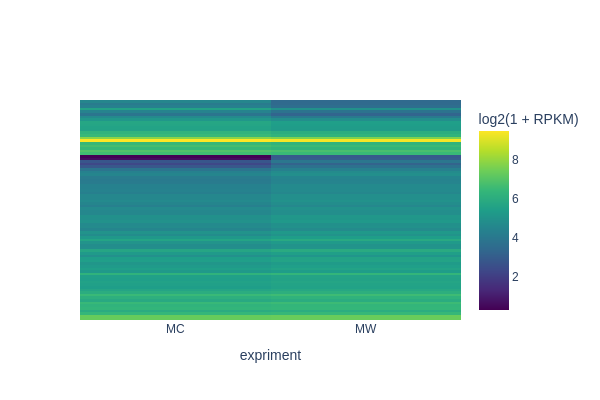

In [155]:
snap.pl.regions(peak_mat, groupby='expriment', peaks=marker_peaks, interactive=False)


In [156]:
from snapatac2._snapatac2 import read_motifs, PyDNAMotif

def cis_bp_mouse(unique: bool = True , path="data/motifdb/Mus_musculus.meme") -> list[PyDNAMotif]:
    motifs = read_motifs(path)
    for motif in motifs:
        motif.name = motif.id.split('+')[0]
    if unique:
        unique_motifs = {}
        for motif in motifs:
            name = motif.name
            if (
                    name not in unique_motifs or 
                    unique_motifs[name].info_content() < motif.info_content()
               ):
               unique_motifs[name] = motif
        motifs = list(unique_motifs.values())
    return motifs


In [160]:
motifs = snap.tl.motif_enrichment(
    motifs=cis_bp_mouse(unique=True,path="data/motifdb/Mus_musculus.meme"),
    regions=marker_peaks,
    genome_fasta=snap.genome.GRCm39,
)


2025-03-04 16:19:12 - INFO - Fetching 84 sequences ...
2025-03-04 16:19:12 - INFO - Computing enrichment ...
100%|██████████| 790/790 [00:29<00:00, 27.19it/s]


In [168]:
motifs['MC'].write_csv("output/AMY_neuron_MC_motif.csv")

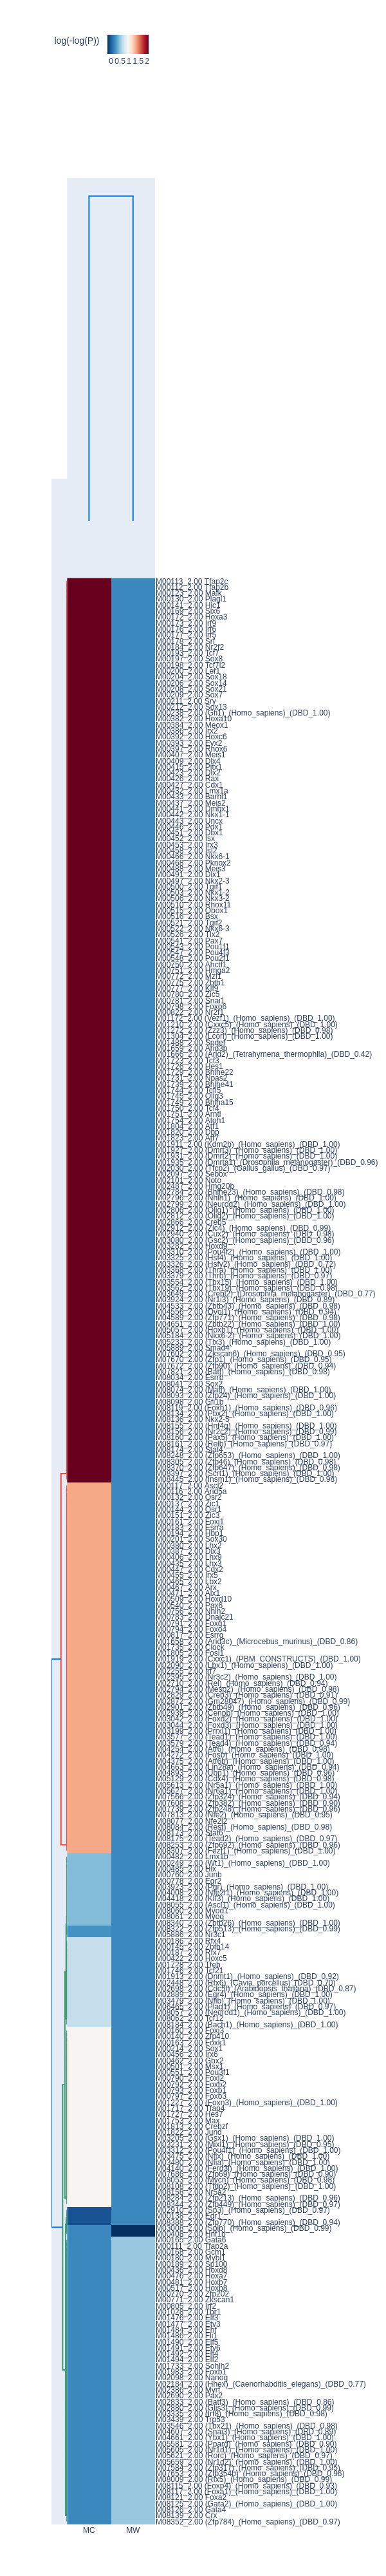

In [162]:
snap.pl.motif_enrichment(motifs, max_fdr=0.0001, height=4000, interactive=False)

In [171]:
motifs = snap.tl.motif_enrichment(
    motifs=cis_bp_mouse(unique=True,path="data/motifdb/uniprobe_mouse.meme"),
    regions=marker_peaks,
    genome_fasta=snap.genome.GRCm39,
)


2025-03-04 16:40:47 - INFO - Fetching 84 sequences ...
2025-03-04 16:40:47 - INFO - Computing enrichment ...
100%|██████████| 386/386 [00:28<00:00, 13.44it/s]


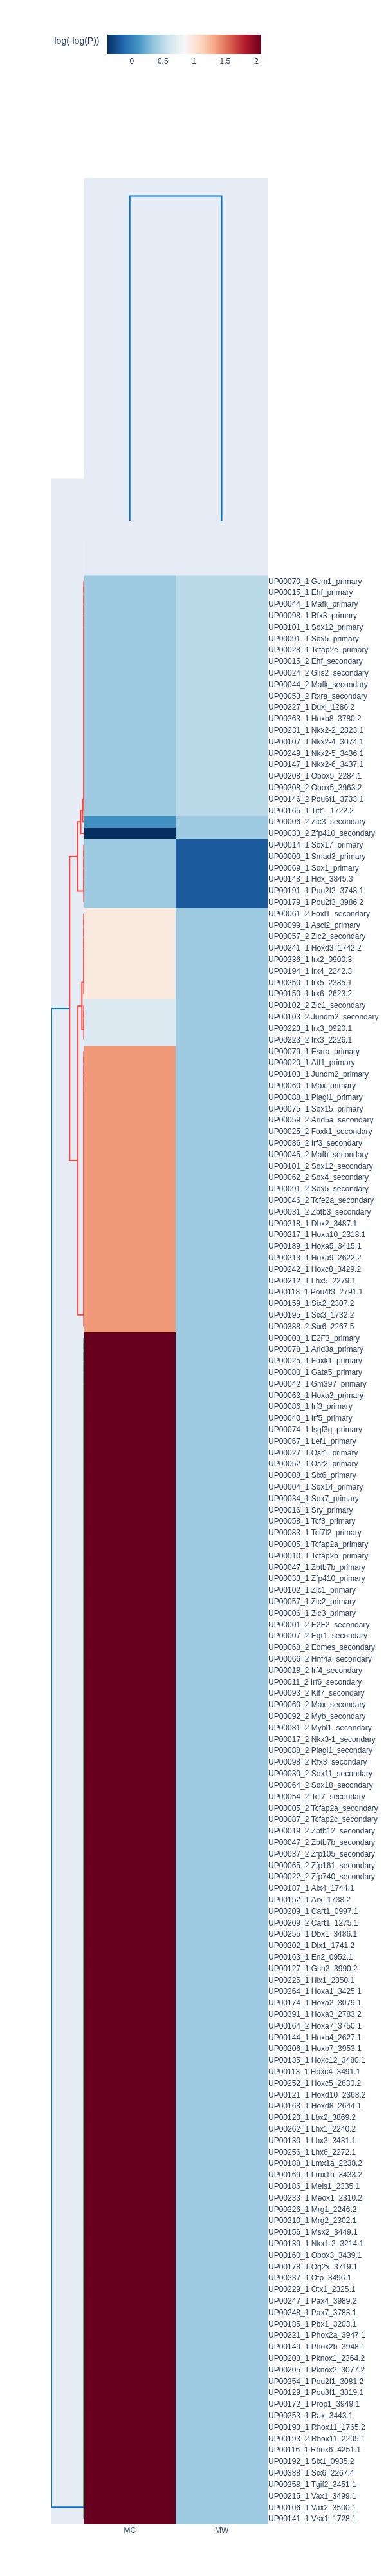

In [172]:
snap.pl.motif_enrichment(motifs, max_fdr=0.0001, height=4000, interactive=False)

In [173]:
motifs['MC'].write_csv("output/AMY_neuron_MC_motif_uniprot.csv")